# Exporting and plotting fitbit data

In [1]:
# This is a python file you need to have in the same directory as your code so you can import it
import gather_keys_oauth2 as Oauth2
import fitbit
import pandas as pd
import datetime
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [3]:
# Load your credentials
load_dotenv(find_dotenv())

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

In [4]:
server=Oauth2.OAuth2Server(CLIENT_ID,
                           CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN=str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN=str(server.fitbit.client.session.token['refresh_token'])
auth2_client=fitbit.Fitbit(CLIENT_ID,
                           CLIENT_SECRET,
                           oauth2=True,
                           access_token=ACCESS_TOKEN,
                           refresh_token=REFRESH_TOKEN)

[23/Oct/2021:23:07:34] ENGINE Listening for SIGTERM.
[23/Oct/2021:23:07:34] ENGINE Listening for SIGHUP.
[23/Oct/2021:23:07:34] ENGINE Listening for SIGUSR1.
[23/Oct/2021:23:07:34] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[23/Oct/2021:23:07:34] ENGINE Started monitor thread 'Autoreloader'.
[23/Oct/2021:23:07:34] ENGINE Serving on http://127.0.0.1:8080
[23/Oct/2021:23:07:34] ENGINE Bus STARTED


127.0.0.1 - - [23/Oct/2021:23:07:36] "GET /?code=ed92c791c3ec2f78c22c07b6bc6215f7eef7c60d&state=nehsaqsqeCFWlTVlOt41YQ5UDdbsNL HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15"


[23/Oct/2021:23:07:37] ENGINE Bus STOPPING
[23/Oct/2021:23:07:37] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[23/Oct/2021:23:07:37] ENGINE Stopped thread 'Autoreloader'.
[23/Oct/2021:23:07:37] ENGINE Bus STOPPED
[23/Oct/2021:23:07:37] ENGINE Bus EXITING
[23/Oct/2021:23:07:37] ENGINE Bus EXITED
[23/Oct/2021:23:07:37] ENGINE Waiting for child threads to terminate...


## Export data from API
#### Options:
__Activity__
- activities/calories
- activities/caloriesBMR
- activities/steps
- activities/distance
- activities/floors
- activities/elevation
- activities/minutesSedentary
- activities/minutesLightlyActive
- activities/minutesFairlyActive
- activities/minutesVeryActive
- activities/activityCalories </br>

__Tracker Activity__
- activities/tracker/calories
- activities/tracker/steps
- activities/tracker/distance
- activities/tracker/floors
- activities/tracker/elevation
- activities/tracker/minutesSedentary
- activities/tracker/minutesLightlyActive
- activities/tracker/minutesFairlyActive
- activities/tracker/minutesVeryActive
- activities/tracker/activityCalories

In [5]:
# auth2_client.time_series(resource="activities/steps", period="1y")

In [6]:
cache = dict()

def get_heart_df_from_server(oneDate):
    oneDayData = auth2_client.intraday_time_series('activities/heart', oneDate, detail_level='1min')
    return (pd.DataFrame(oneDayData["activities-heart-intraday"]["dataset"])
            .assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + x["time"]))
           )

def get_heart_df(oneDate):
    if f"{str(oneDate)}_heart" not in cache:
        cache[f"{str(oneDate)}_heart"] = get_heart_df_from_server(oneDate)

    return cache[f"{str(oneDate)}_heart"]

def get_steps_df_from_server(oneDate):
    oneDayData = auth2_client.intraday_time_series('activities/steps', oneDate, detail_level='1min')
    return (pd.DataFrame(oneDayData["activities-steps-intraday"]["dataset"])
            .assign(**{"time": lambda x: pd.to_datetime(str(f"{oneDate} ") + x["time"]),
                   "steps_cumsum": lambda x: x["value"].cumsum()})
           )

def get_steps_df(oneDate):
    if f"{str(oneDate)}_steps" not in cache:
        cache[f"{str(oneDate)}_steps"] = get_steps_df_from_server(oneDate)

    return cache[f"{str(oneDate)}_steps"]

def get_calories_df_from_server(oneDate):
    oneDayData = auth2_client.intraday_time_series('activities/calories', oneDate, detail_level='1min')
    return (pd.DataFrame(oneDayData["activities-calories-intraday"]["dataset"])
            .assign(**{"time": lambda x: pd.to_datetime(str(f"{oneDate} ") + x["time"]),
                   "calories_cumsum": lambda x: x["value"].cumsum()})
           )

def get_calories_df(oneDate):
    if f"{str(oneDate)}_calories" not in cache:
        cache[f"{str(oneDate)}_calories"] = get_calories_df_from_server(oneDate)

    return cache[f"{str(oneDate)}_calories"]

def get_year_df_from_server(feature):
    tmp=auth2_client.time_series(resource=f"activities/{feature}", period="1y")
    return (pd.DataFrame(tmp[f"activities-{feature}"]).assign(**{"date": lambda x: pd.to_datetime(x["dateTime"]),
                                                         feature: lambda x: x["value"].astype(int)})
           )

def get_year_df(feature):
    if f"{str(feature)}_year" not in cache:
        cache[f"{str(feature)}_year"] = get_year_df_from_server(feature)

    return cache[f"{str(feature)}_year"]

In [7]:
# tmp=auth2_client.time_series(resource="activities/steps", period="1y")

# year_df = pd.DataFrame(tmp["activities-steps"]).assign(**{"date": lambda x: pd.to_datetime(x["dateTime"]),
#                                                          "steps": lambda x: x["value"].astype(int)})

# _ = plt.figure(figsize=(20, 5))
# ax = sns.lineplot(data=year_df,
#                  x="date",
#                  y="steps",
#                  color="orange"
#                  )

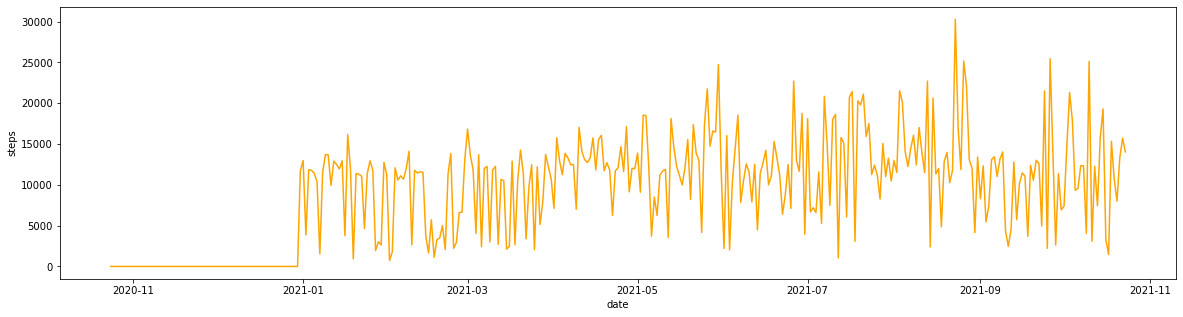

In [28]:
feature="steps"
year_df = get_year_df(feature)

_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=year_df,
                 x="date",
                 y=feature,
                 color="orange"
                 )

## Heart rate year summary

In [9]:
feature = "heart"

In [10]:
tmp=auth2_client.time_series(resource=f"activities/{feature}", period="1y")

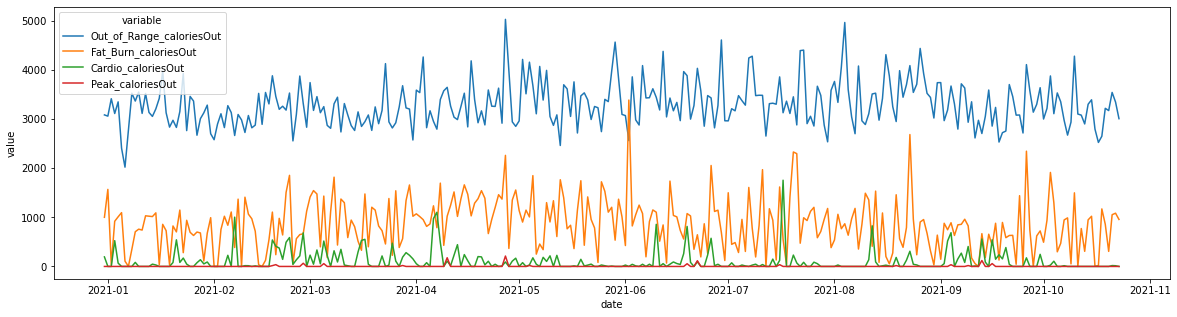

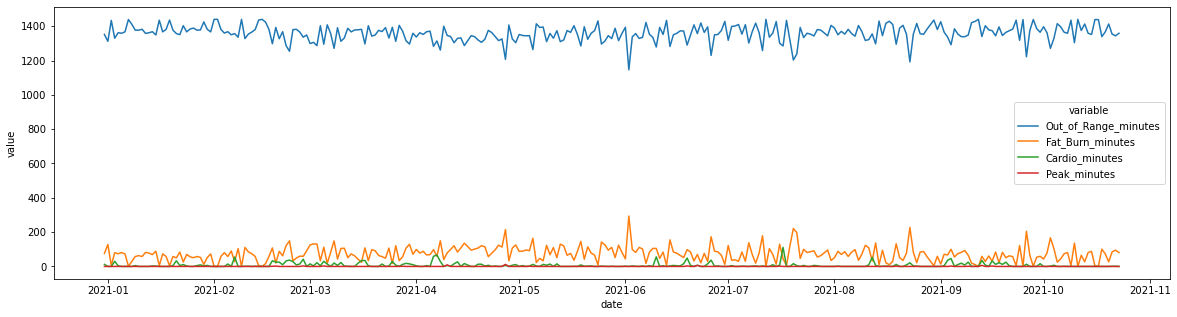

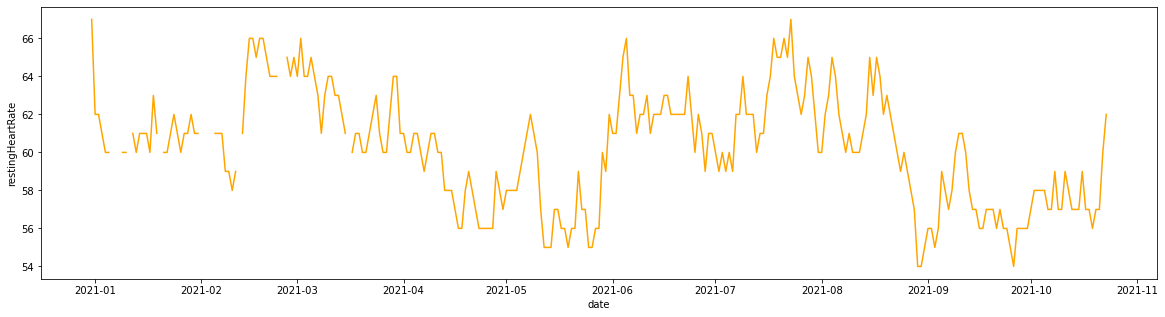

In [11]:
tmp_heart_df = (pd.DataFrame(tmp['activities-heart'])
 .assign(**{"date": lambda x: pd.to_datetime(x["dateTime"]),
             "restingHeartRate": lambda x: x
            .loc[:, "value"]
            .apply(pd.Series)
            .loc[:, "restingHeartRate"]
           }
        )
 # .loc[:, "heartRateZones"]
 # .apply(pd.Series)
)

tmp_all_hearts_df = pd.concat([(tmp_heart_df
 .loc[:, "value"]
            .apply(pd.Series)
            .loc[:, "heartRateZones"]
 .apply(pd.Series)
 .loc[:, x]
 .apply(pd.Series)
  [["caloriesOut", "minutes"]]
) for x in range(0,4)], axis=1)

zone_names_list = [x['name'].replace(" ", "_") for x in tmp_heart_df.loc[:, "value"].iloc[0]["heartRateZones"]]

tmp_all_hearts_df.columns=flatten([[f"{x}_caloriesOut", f"{x}_minutes"] for x in zone_names_list])

heart_df = pd.merge(tmp_heart_df[["date", "restingHeartRate"]], tmp_all_hearts_df, left_index=True, right_index=True)

_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=heart_df
                  .set_index("date")
                  .filter(regex="calories")
                  .reset_index()
                  .melt(id_vars="date"),
                     x="date",
                     y="value",
                  hue="variable"
                     )
_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=heart_df
                  .set_index("date")
                  .filter(regex="minutes")
                  .reset_index()
                  .melt(id_vars="date"),
                     x="date",
                     y="value",
                  hue="variable"
                     )

_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=tmp_heart_df,
                 x="date",
                 y="restingHeartRate",
                 color="orange"
                 )

In [35]:
combi_df = pd.merge(year_df[["date", "steps"]], heart_df, on="date", how="inner").dropna()

In [36]:
combi_df.head()

,date,steps,restingHeartRate,Out_of_Range_caloriesOut,Out_of_Range_minutes,Fat_Burn_caloriesOut,Fat_Burn_minutes,Cardio_caloriesOut,Cardio_minutes,Peak_caloriesOut,Peak_minutes
68,2020-12-31,11710,67.0,3087.15645,1352.0,1000.88548,76.0,194.48415,12.0,0.0,0.0
69,2021-01-01,12977,62.0,3062.08560,1312.0,1569.62680,128.0,0.00000,0.0,0.0,0.0
70,2021-01-02,3854,62.0,3416.60280,1434.0,36.16080,6.0,0.00000,0.0,0.0,0.0
71,2021-01-03,11853,61.0,3115.36933,1330.0,920.37935,80.0,525.12714,30.0,0.0,0.0
72,2021-01-04,11774,60.0,3352.58344,1362.0,1010.89687,74.0,67.50168,4.0,0.0,0.0


In [99]:
minutes_columns = combi_df.filter(regex="minutes").columns.tolist()
calories_columns = combi_df.filter(regex="calories").columns.tolist()

In [101]:
(combi_df
 .drop(calories_columns, axis=1)
 .select_dtypes("number")
 .sum()
 .to_frame(name="totals")
 .style.format("{:.1f}")
)

,totals
steps,3273815.0
restingHeartRate,17166.0
Out_of_Range_minutes,387002.0
Fat_Burn_minutes,21359.0
Cardio_minutes,1983.0
Peak_minutes,56.0


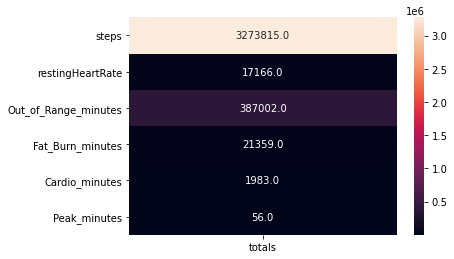

In [104]:
_ = sns.heatmap(combi_df
 .drop(calories_columns, axis=1)
 .select_dtypes("number")
 .sum()
 .to_frame(name="totals"),
                fmt='.1f',
                annot=True
               )

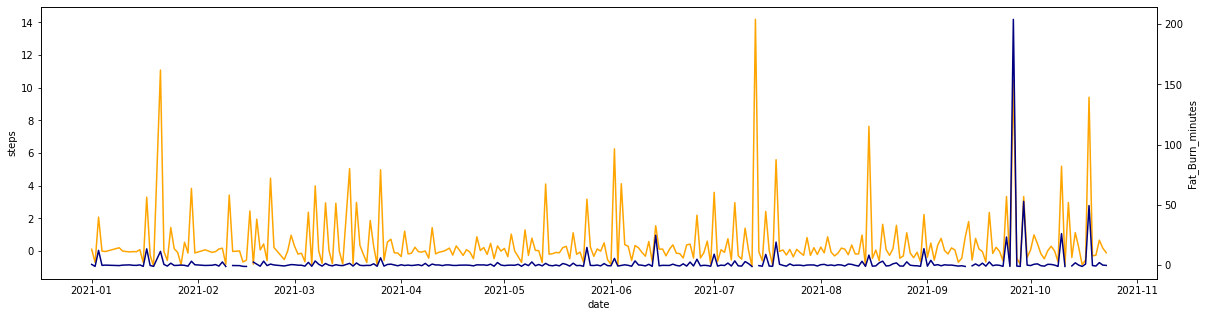

In [51]:
_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=combi_df
                  .set_index("date")
                  .pct_change()
                  .reset_index(),
                 x="date",
                 y="steps",
                 color="orange"
                )
ax2 = ax.twinx()
_ = sns.lineplot(data=combi_df
                  .set_index("date")
                  .pct_change()
                  .reset_index(),
                 x="date",
                 y="Fat_Burn_minutes",
                 color="navy",
                  ax=ax2
                 )

In [42]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from typing import Callable, Dict, Union

def apply_scaling(df: pd.DataFrame, 
                  method: Union[Callable, str] = "MinMax", 
                  kwargs: Dict = {}):
    if method == "MinMax":
        scal_df = pd.DataFrame(MinMaxScaler(**kwargs).fit_transform(df), 
             index = df.index,
            columns = df.columns)
    elif method == "Standard":
        scal_df = pd.DataFrame(StandardScaler(**kwargs).fit_transform(df), 
             index = df.index,
            columns = df.columns)
    else:
        scal_df = pd.DataFrame(method(**kwargs).fit_transform(df), 
             index = df.index,
            columns = df.columns)
    return scal_df 

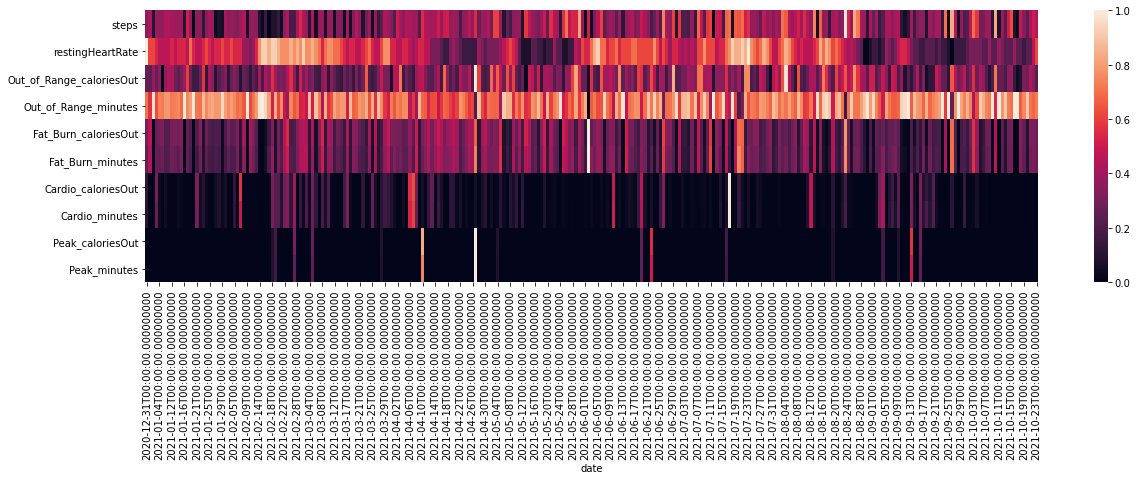

In [53]:
_ = plt.figure(figsize=(20, 5))
_ = sns.heatmap(combi_df
                .set_index("date")
                .pipe(apply_scaling, "MinMax")
                .T)

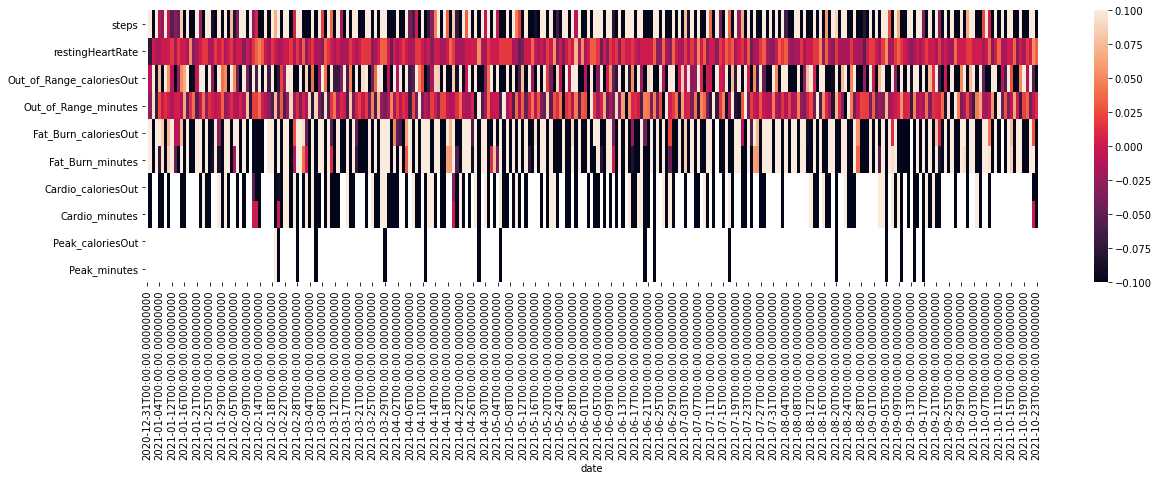

In [52]:
_ = plt.figure(figsize=(20, 5))
_ = sns.heatmap(combi_df
                  .set_index("date")
                  .pct_change()
                .T)

In [86]:
# combi_df.corr(min_periods=None)

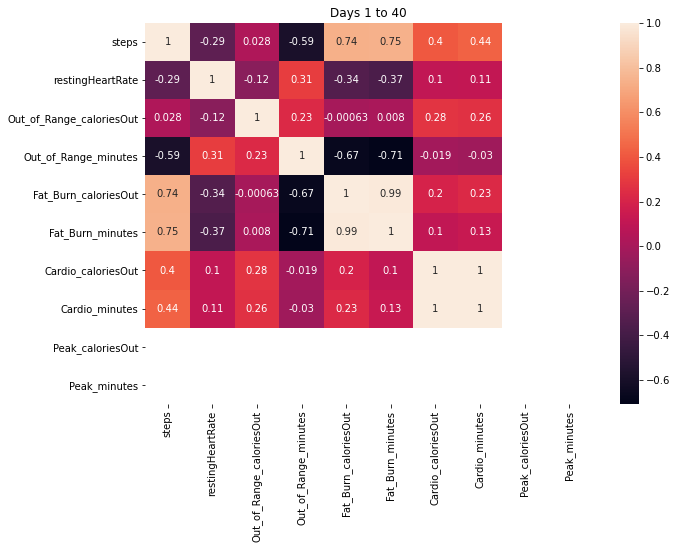

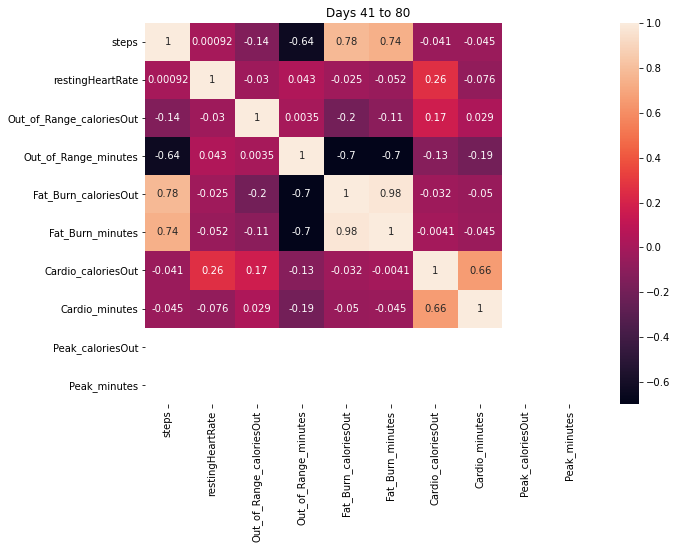

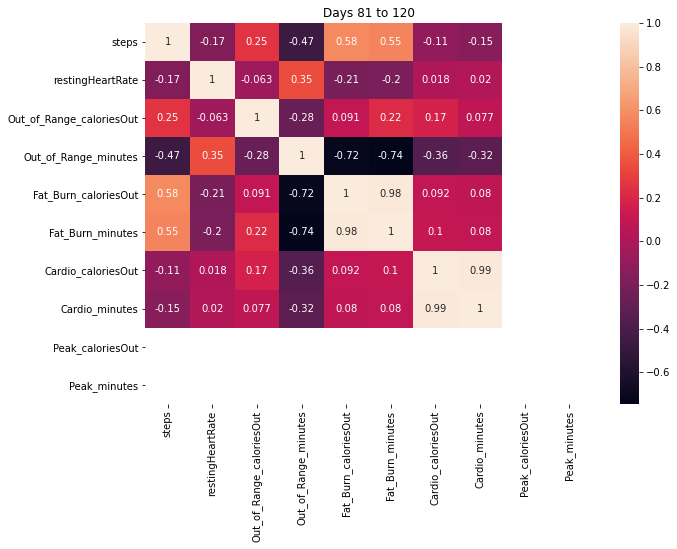

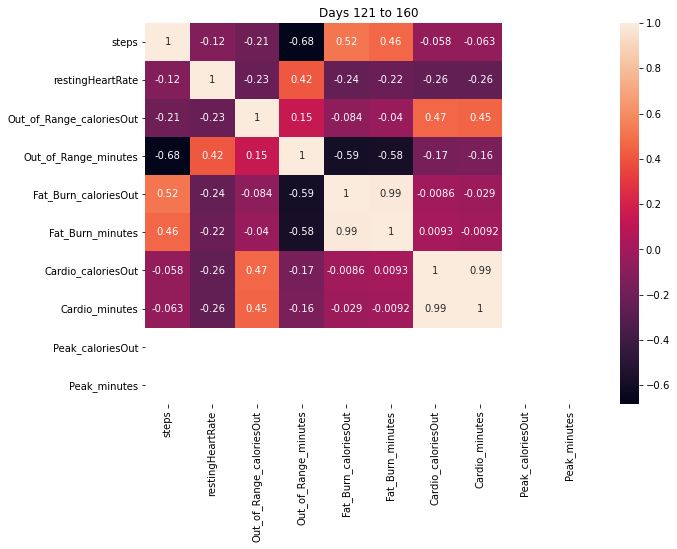

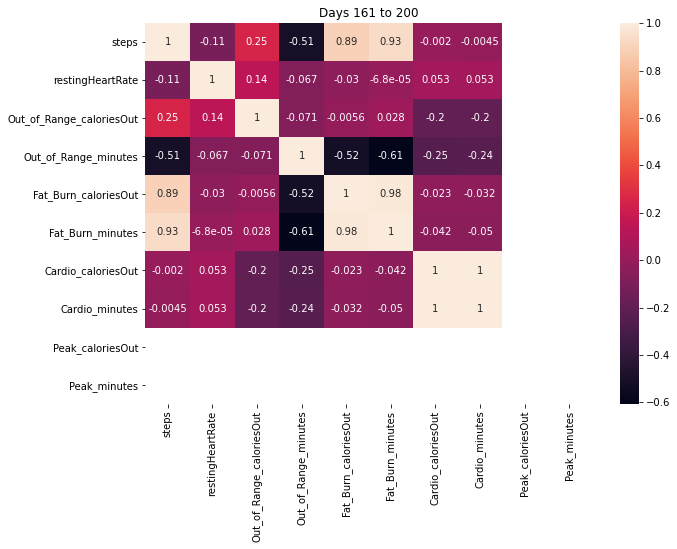

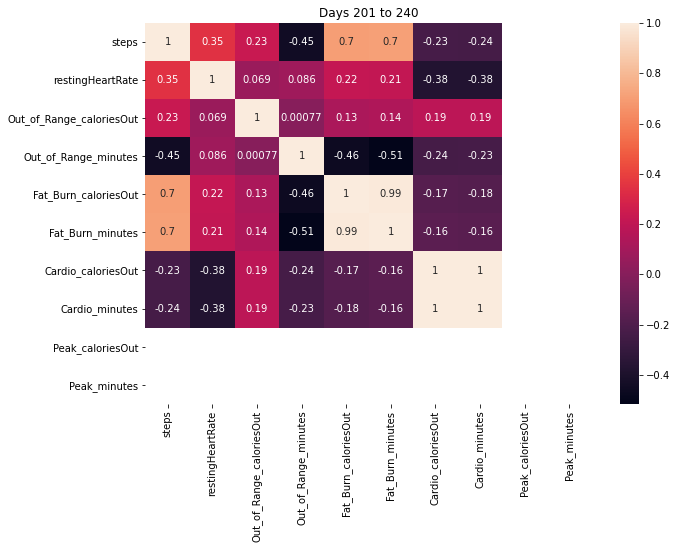

In [85]:
for i in [0, 40, 80, 120, 160, 200]:
    _ = plt.figure(figsize=(10, 7))
    _ = sns.heatmap(combi_df
                    .iloc[1+i:40+i, :]
                    .set_index("date")
                    .pct_change()
                    .corr(min_periods=None)
                    .T,
                   annot=True)
    _ = plt.title(f"Days {1+i} to {40+i}")

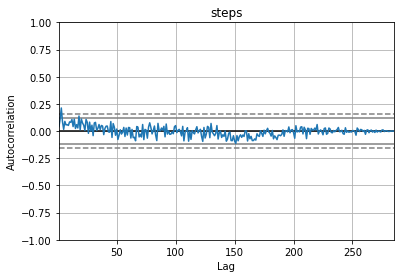

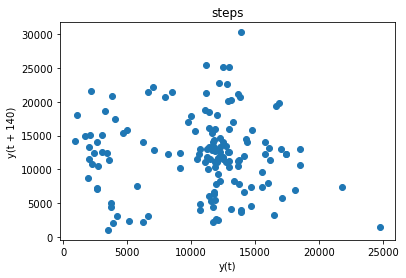

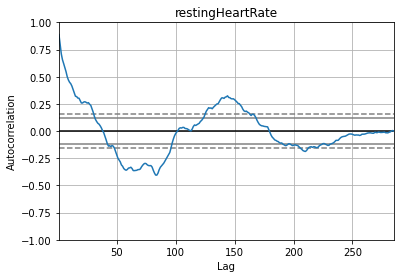

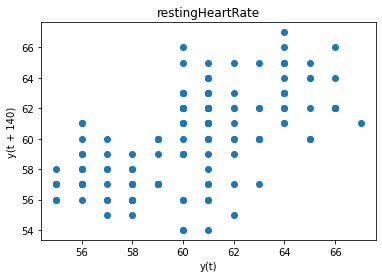

In [69]:
for column_name in combi_df.columns.tolist()[1:3]:
    _ = pd.plotting.autocorrelation_plot(combi_df[column_name])
    _ = plt.title(column_name)
    _ = plt.show()
    
    _ = pd.plotting.lag_plot(combi_df[column_name], lag=140)
    _ = plt.title(column_name)
    _ = plt.show()

In [12]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

## Sleep year summary

In [18]:
oneDate = datetime.datetime.now().date() - datetime.timedelta(2)

In [19]:
monthDiffDate = datetime.datetime.now().date() - datetime.timedelta(32)

In [20]:
feature = "sleep"

In [21]:
url = "{0}/{1}/user/{2}/{resource}/date/{base_date}/{end}.json".format(
            *self._get_common_args(user_id),
            resource=resource,
            base_date=self._get_date_string(base_date),
            end=end
        )

NameError: name 'self' is not defined

In [26]:
url = "{0}/{1}/user/{2}/{resource}/date/{base_date}/{end}.json"
url = f"https://api.fitbit.com/1.2/user/{CLIENT_SECRET}/sleep/date/{monthDiffDate}/{oneDate}.json"

In [27]:
tmp_2 = auth2_client.make_request(url)

HTTPForbidden: API client is not authorized by the resource owner to access the resource requested. Visit https://dev.fitbit.com/docs/oauth2 for more information on the Fitbit Web API authorization process.

In [ ]:
tmp=auth2_client.time_series(resource=f"{feature}", period="1y")

In [ ]:
heart_df = get_heart_df(oneDate)
steps_df = get_steps_df(oneDate)
calories_df = get_calories_df(oneDate)

In [ ]:
_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=heart_df,
                 x="time",
                 y="value",
                 color="orange"
                 )

# _ = plt.figure(figsize=(20, 5))

In [ ]:
_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=steps_df,
                 x="time",
                 y="value",
                 color="orange"
                )
ax2 = ax.twinx()
_ = sns.lineplot(data=steps_df,
                 x="time",
                 y="steps_cumsum",
                 color="navy",
                  ax=ax2
                 )

In [ ]:
_ = plt.figure(figsize=(20, 5))
ax = sns.lineplot(data=calories_df,
                 x="time",
                 y="value",
                 color="orange"
                )
ax2 = ax.twinx()
_ = sns.lineplot(data=calories_df,
                 x="time",
                 y="calories_cumsum",
                 color="navy",
                  ax=ax2
                 )

In [ ]:
# # This is the date of data that I want.
# # You will need to modify for the date you want
# # oneDate = pd.datetime(year = 2021, month = 1, day = 21)
# oneDate = datetime.datetime.now().date() - datetime.timedelta(6)
# oneDayData = auth2_client.intraday_time_series('activities/heart', oneDate, detail_level='1sec')

# oneDate

# df = pd.DataFrame(oneDayData["activities-heart-intraday"]["dataset"])
# df = df.assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["time"]))

# display(df.head()), df.shape

<!-- ## Today's heart rate data -->

In [ ]:
# _ = plt.figure(figsize=(20, 5))
# _ = sns.lineplot(data=df,
#                  x="time",
#                  y="value"
#                  )

# oneDayData = auth2_client.intraday_time_series('activities/steps', oneDate, detail_level='1min')

# df = pd.DataFrame(oneDayData["activities-steps-intraday"]["dataset"])
# df = df.assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["time"]))

# display(df.head()), df.shape

# _ = plt.figure(figsize=(20, 5))
# _ = sns.lineplot(data=df,
#                  x="time",
#                  y="value"
#                  )

# oneDayData = auth2_client.intraday_time_series('activities/distance', oneDate, detail_level='1min')

# df = pd.DataFrame(oneDayData["activities-distance-intraday"]["dataset"])
# df = (df.assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["time"]))
#       .assign(value = lambda x: x["value"].cumsum())
#      )

# display(df.head()), df.shape

# _ = plt.figure(figsize=(20, 5))
# _ = sns.lineplot(data=df,
#                  x="time",
#                  y="value"
#                  )

In [ ]:
# oneDayData = auth2_client.sleep(oneDate)

In [ ]:
# df = pd.DataFrame(oneDayData["sleep"][0]["minuteData"])
# df = (df.assign(dateTime = lambda x: pd.to_datetime(str(f"{oneDate} ") + df["dateTime"]))
# #       .assign(value = lambda x: x["value"].cumsum())
#      )

# display(df.head()), df.shape

In [ ]:
# _ = plt.figure(figsize=(20, 5))
# _ = sns.lineplot(data=df,
#                  x="dateTime",
#                  y="value"
#                  )
# _ = sns.scatterplot(data=df,
#                  x="dateTime",
#                  y="value"
#                  )

In [ ]:
# str(datetime.datetime.now())

In [ ]:
# data_list = pd.date_range(start='1/1/2021', end=str(datetime.datetime.now())).astype(str).tolist()

In [ ]:
# data_list[-1]

In [ ]:
# auth2_client.activities()

In [ ]:
# dir(fitbit.Fitbit)

In [15]:
monthDiffDate = datetime.datetime.now().date() - datetime.timedelta(32)

In [ ]:
date_choice_list = pd.date_range(start=str(monthDiffDate), end=str(datetime.datetime.now())).astype(str).tolist()[:-2]

In [ ]:
dfs_list = list()
day_number = 1
for oneDate in date_choice_list:
    # oneDayData = auth2_client.intraday_time_series('activities/heart', oneDate, detail_level='1min')
    df = get_heart_df(oneDate)
    df = (df
          # .assign(time = lambda x: pd.to_datetime(str(f"{oneDate} ") + x["time"]))
          .rename(columns={"value": f"day_number_{day_number}_value"})
           .assign(hour=lambda d: d["time"].dt.hour)
         .assign(minute=lambda d: d["time"].dt.minute)
         .drop("time", axis=1)
          .set_index(["hour", "minute"])
         )
    dfs_list.append(df)
    day_number += 1

In [ ]:
oneDate

In [ ]:
tmp_df = pd.concat(dfs_list, axis=1)

In [ ]:
_ = plt.figure(figsize=(20, 7))
_ = sns.heatmap(tmp_df.T)

In [ ]:
stop!

In [ ]:
tmp_df.index = [str(x).replace(", ", "-").replace("(", "").replace(")", "") for x in tmp_df.index.values]

In [ ]:
_ = plt.figure(figsize=(20, 7))
_ = sns.heatmap(tmp_df.T)

In [ ]:
_ = tmp_df.to_csv(f"data/{oneDate}_heart_min.csv")

In [ ]:
import glob

csv_list = glob.glob("data/*")

[x for x in csv_list if oneDate in x][0]

if len([x for x in csv_list if oneDate in x]) > 0:
    tmp_df = pd.read_csv([x for x in csv_list if oneDate in x][0], index_col=0)

In [ ]:
str(datetime.datetime.now().date() - datetime.timedelta(2))

In [ ]:
tmp_df.index

In [ ]:
tmp_df.set_index(tmp_df.index.str.split("-", expand=True))